In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb  # 导入XGBoost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import features_selection as fs

# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

In [3]:
train_x,train_y,test_x,features = fs.process_features(train, test, label)

In [4]:
train_x.shape

(60000, 71)

In [5]:
# 设置随机种子，保证结果可复现
np.random.seed(42)

# 假设train_x（DataFrame或数组）和train_y（Series或数组）是已有的训练数据
# 请确保在实际使用时已经正确加载了这两个变量

# 确保train_y是一维数组
if isinstance(train_y, pd.Series):
    train_y = train_y.values

# 获取特征数量和特征名称
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]


绘制特征相关性热图...
特征相关性热图保存成功！


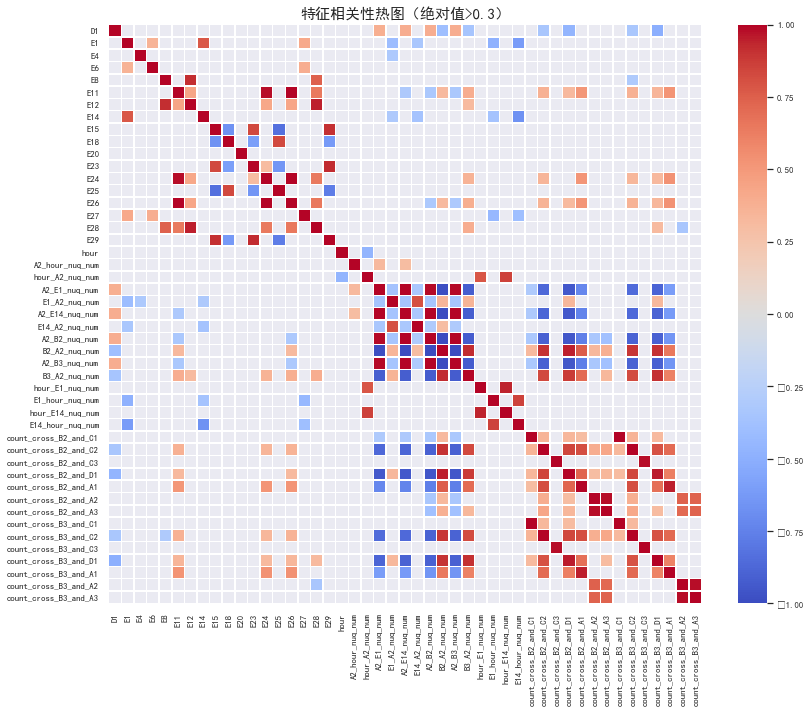

In [6]:
# 特征相关性热图
print("绘制特征相关性热图...")
# 选择数值型特征计算相关性
numeric_features = train_x.select_dtypes(include=['int64', 'float64']).columns
# 排除ID和标签列
numeric_features = [f for f in numeric_features if f not in ['ID', 'label']]
if len(numeric_features) > 0:
    corr_matrix = train_x[numeric_features].corr()
    # 绘制热图（只显示绝对值大于0.3的相关性）
    plt.figure(figsize=(12, 10))
    mask = np.abs(corr_matrix) < 0.3  # 掩盖低相关性
    sns.heatmap(
        corr_matrix, 
        mask=mask, 
        annot=False,  # 显示相关系数
        cmap='coolwarm', 
        fmt='.2f', 
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.title('特征相关性热图（绝对值>0.3）', fontsize=15)
    plt.tight_layout()

    # 保存图片
    plt.savefig('./chart_output/fe_heatmap.jpg', dpi=300, bbox_inches='tight')
    
    print('特征相关性热图保存成功！')
    
    plt.show()
else:
    print("无可用的数值型特征用于绘制相关性热图")


In [7]:
# XGBoost参数配置（0.90版本）
def get_xgb_params():
    """XGBoost 0.90版本参数配置"""
    return {
        'booster': 'gbtree',
        'objective': 'binary:logistic',  # 二分类问题
        'eval_metric': 'auc',  # 评估指标
        'learning_rate': 0.05,
        'max_depth': 5,  # XGBoost通常需要限制树深
        'subsample': 0.8,  # 类似bagging_fraction
        'colsample_bytree': 0.8,  # 类似feature_fraction
        'gamma': 0,  # 叶节点分裂的最小损失减少
        'min_child_weight': 1,  # 子节点最小样本权重和
        'scale_pos_weight': 1,  # 类别不平衡时调整
        'seed': 42,
        'nthread': -1,  # 多线程
        'verbosity': 0
    }

In [8]:
# 模型评估指标
def calculate_metrics(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc, 'ks': ks, 'best_f1': best_f1,
        'best_threshold': best_threshold, 'thresholds': thresholds,
        'f1_scores': f1_scores, 'precision_scores': precision_scores,
        'recall_scores': recall_scores, 'fpr': fpr, 'tpr': tpr
    }

# 指标可视化（保持不变）
def plot_metrics(metrics, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 关键指标
    ax1 = axes[0, 0]
    metrics_text = (f"AUC: {metrics['auc']:.4f}\nKS: {metrics['ks']:.4f}\n"
                   f"最佳F1: {metrics['best_f1']:.4f}\n最佳阈值: {metrics['best_threshold']:.2f}")
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # ROC曲线
    ax2 = axes[0, 1]
    ax2.plot(metrics['fpr'], metrics['tpr'], label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # KS曲线
    ax3 = axes[1, 0]
    ax3.plot(metrics['fpr'], label='FPR')
    ax3.plot(metrics['tpr'], label='TPR')
    ax3.plot(metrics['tpr'] - metrics['fpr'], label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 阈值指标
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', 
                label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

开始十折交叉验证训练...

第 1 折训练...
[0]	train-auc:0.673247	valid-auc:0.666019
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.752611	valid-auc:0.712947
[200]	train-auc:0.785119	valid-auc:0.718136
[300]	train-auc:0.810162	valid-auc:0.720556
[400]	train-auc:0.831202	valid-auc:0.721298
Stopping. Best iteration:
[350]	train-auc:0.820993	valid-auc:0.721497

第 1 折 - AUC: 0.7215, KS: 0.3316, 最佳F1: 0.4045

第 2 折训练...
[0]	train-auc:0.671077	valid-auc:0.666613
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.754679	valid-auc:0.715345
[200]	train-auc:0.786563	valid-auc:0.720511
[300]	train-auc:0.811516	valid-auc:0.721814
Stopping. Best iteration:
[337]	train-auc:0.819498	valid-auc:0.722632

第 2 折 - AUC: 0.7226, KS: 0.3321, 最佳F1: 0.4011

第 3 折训练...
[0]	train-auc:0.668368	valid-auc:0.667

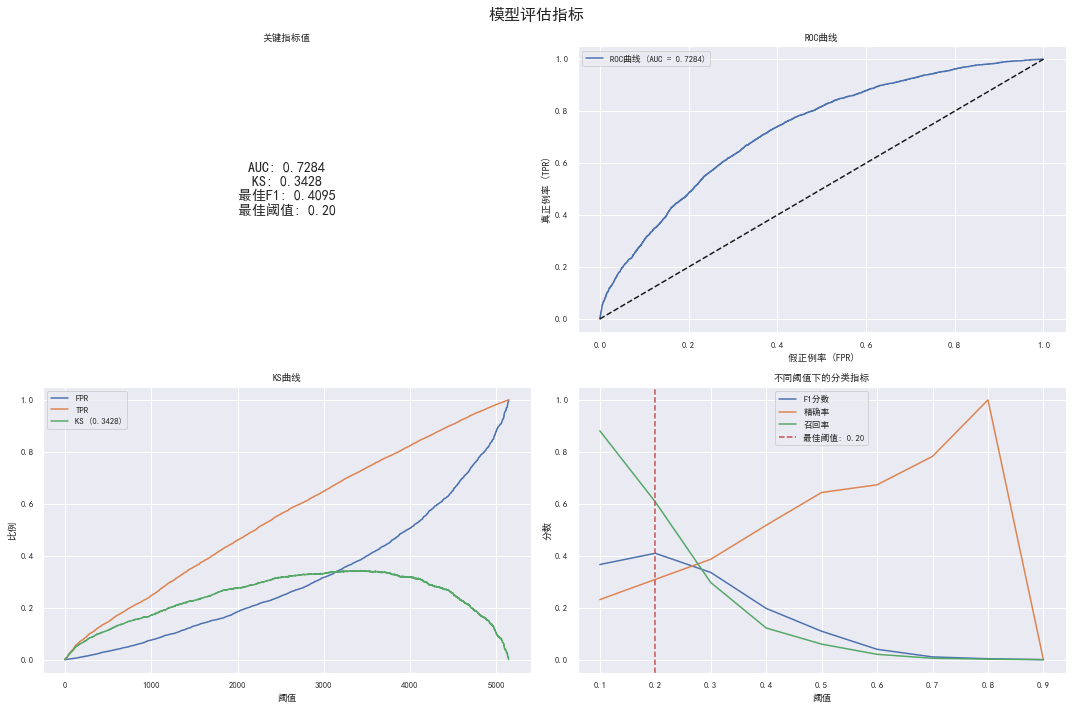


十折交叉验证结果:
平均AUC: 0.7242 ± 0.0030
平均KS: 0.3355 ± 0.0052
平均最佳F1: 0.4050 ± 0.0035


In [9]:
# 十折交叉验证训练
print("开始十折交叉验证训练...")
params = get_xgb_params()
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train_x))
test_preds = np.zeros(len(test_x))
feature_importance = np.zeros(len(features))  # 初始化与特征长度一致的数组
auc_scores = []
ks_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f"\n第 {fold+1} 折训练...")
    X_train, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_train, y_val = train_y[train_idx], train_y[val_idx]
    
    # 转换为DMatrix格式
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # 训练模型
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # 预测与评估
    val_pred = model.predict(dval, ntree_limit=model.best_ntree_limit)
    oof_preds[val_idx] = val_pred
    
    dtest = xgb.DMatrix(test_x)
    test_preds += model.predict(dtest, ntree_limit=model.best_ntree_limit) / kf.n_splits
    
    # 修正：将XGBoost的字典类型特征重要性转换为数组
    fold_importance = model.get_score(importance_type='gain')  # 字典：{特征名: 重要性}
    # 初始化当前折的重要性数组
    fold_importance_array = np.zeros(len(features))
    for i, feat in enumerate(features):
        # 若特征在字典中存在，则赋值；否则为0
        fold_importance_array[i] = fold_importance.get(feat, 0)
    # 累加（除以折数求平均）
    feature_importance += fold_importance_array / kf.n_splits
    
    # 计算指标（其余部分不变）
    metrics = calculate_metrics(y_val, val_pred)
    auc_scores.append(metrics['auc'])
    ks_scores.append(metrics['ks'])
    f1_scores.append(metrics['best_f1'])
    
    print(f"第 {fold+1} 折 - AUC: {metrics['auc']:.4f}, KS: {metrics['ks']:.4f}, 最佳F1: {metrics['best_f1']:.4f}")
    
    if fold == kf.n_splits - 1:
        print("\n最后一折指标可视化:")
        plot_metrics(metrics)

# 整体评估
print("\n十折交叉验证结果:")
print(f"平均AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"平均KS: {np.mean(ks_scores):.4f} ± {np.std(ks_scores):.4f}")
print(f"平均最佳F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

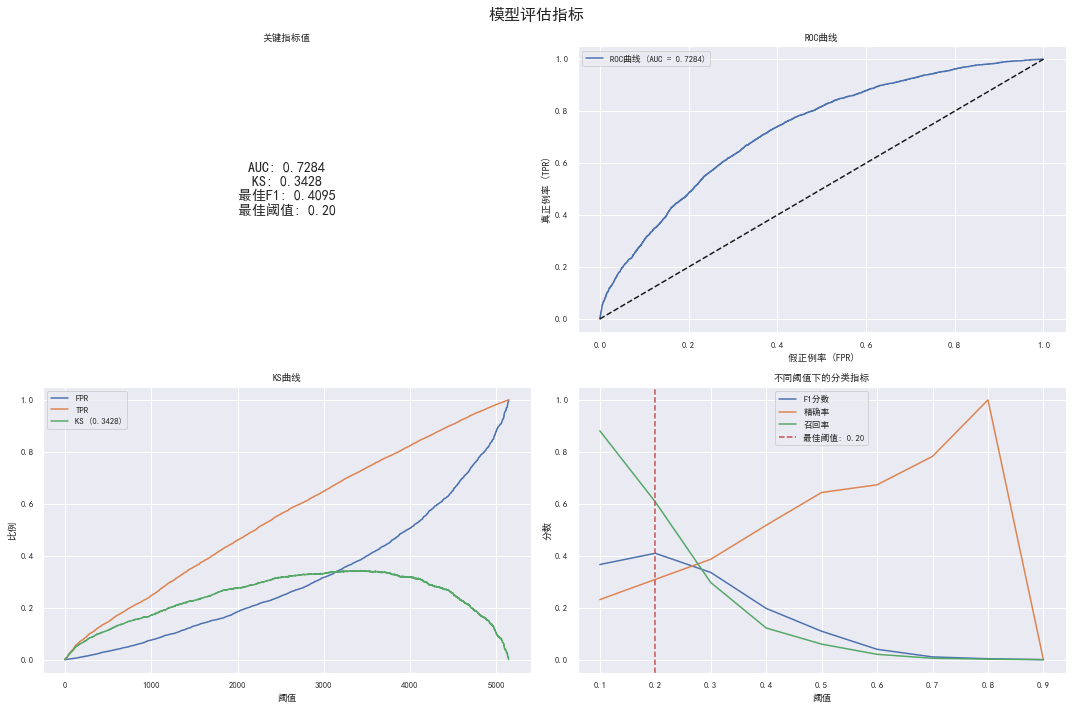

In [10]:
# 绘制评估指标可视化
plot_metrics(metrics)

In [11]:
# 特征重要性可视化（保持不变）
def plot_feature_importance(importance, feature_names, figsize=(12, 8), top_n=50):
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    

    
    #计算特征重要性占比
    total_importance = feat_imp['importance'].sum()
    feat_imp['percentage'] = (feat_imp['importance']/total_importance)*100
    
    feat_imp.to_csv('./chart_output/xgb_10fold_fea_imp.csv',float_format = "%.2f",index = False)
    print('特征重要性结果输出成功！')
    

   
    
    
    plt.figure(figsize=figsize)
    # 绘制柱状图
    ax = sns.barplot(x='importance', y='feature', data=feat_imp)
    plt.title(f'特征重要性(前{top_n}个)', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    
    # 获取y轴上的特征名称列表
    y_ticks = [tick.get_text() for tick in ax.get_yticklabels()]
    
    # 在每个柱子旁添加占比文本标注
    for i, p in enumerate(ax.patches):
        # 获取柱子长度（重要性数值）、对应 y 轴标签（特征名）位置等信息
        width = p.get_width()  
        y_coord = p.get_y() + p.get_height() / 2  
        # 获取当前柱子对应的特征名称
        feature_name = y_ticks[i]
        # 格式化占比显示，保留两位小数
        percentage = feat_imp[feat_imp['feature'] == feature_name]['percentage'].values[0]
        percentage_text = f'{percentage:.2f}%'  
        # 在柱子右侧添加文本，水平居左对齐，垂直居中
        ax.text(width + 0.01, y_coord, percentage_text, va='center')  
    plt.tight_layout()
    
    # 保存图片
    plt.savefig('./chart_output/xgb_10fold_fe_imp.jpg', dpi=300, bbox_inches='tight')
    
    print('特征重要性图保存成功！')
    
    plt.show()

特征重要性结果输出成功！
特征重要性图保存成功！


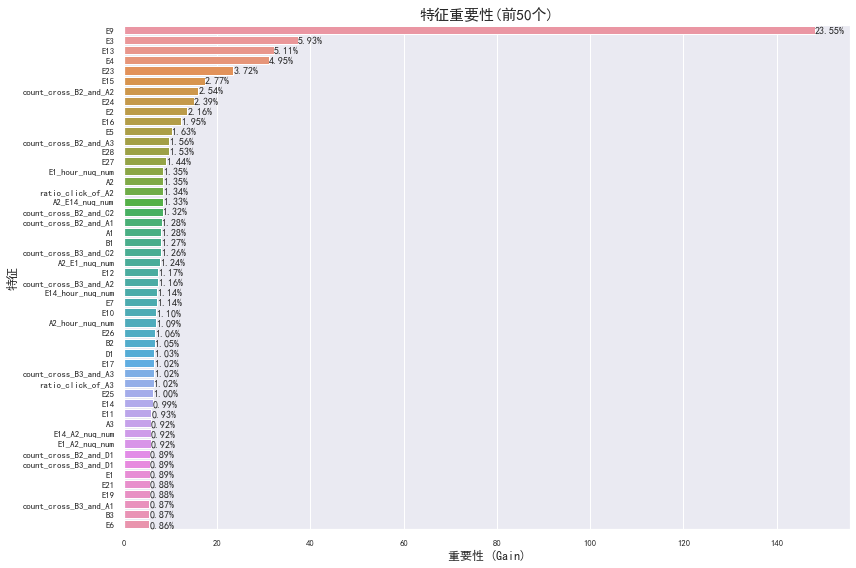

In [12]:
# 特征重要性可视化
plot_feature_importance(feature_importance, features)

In [13]:
# 保存模型和预测结果
print("\n保存模型和预测结果...")
# 保存最后一折模型作为代表
with open('./models/xgb_10fold_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 生成提交文件
sub['pred'] = test_preds
sub.to_csv('./sub/xgb_10fold_model.csv', index=False)
print("提交文件已保存为 xgb_10fold_model.csv")


保存模型和预测结果...
提交文件已保存为 xgb_10fold_model.csv


In [14]:
# 加载模型并对测试集进行预测
def load_model_and_predict(model_path, test_data):
    """
    加载保存的模型并对测试集进行预测
    
    参数:
    model_path: 模型保存路径
    test_data: 测试数据集（包含特征列）
    features: 特征列名列表
    
    返回:
    测试集预测概率
    """
    # 加载模型
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"模型加载成功: {model_path}")
    except Exception as e:
        print(f"模型加载失败: {str(e)}")
        return None
    
    dtest = xgb.DMatrix(test_data)
    
    # 进行预测
    print("开始预测...")
    test_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

    
    return test_pred

In [15]:
# 加载模型并预测
model_path = './models/xgb_10fold_model.pkl'  # 模型保存路径
test_predictions = load_model_and_predict(model_path, test_x)
    
# 如果预测成功，更新提交文件
if test_predictions is not None:
    sub['pred'] = test_predictions
    sub.to_csv('./sub/xgb_10fold_model.csv', index=False)
    print("测试集预测结果已保存为 xgb_10fold_model.csv")

模型加载成功: ./models/xgb_10fold_model.pkl
开始预测...
测试集预测结果已保存为 xgb_10fold_model.csv


In [16]:
sub.head()

,ID,label,pred
0,1,0.1,0.259102
1,4,0.1,0.176729
2,6,0.1,0.208673
3,8,0.1,0.391321
4,10,0.1,0.239464
